### include the necessary libraries if they are not included

In [65]:
import os
import glob
import librosa
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from pydub import AudioSegment

### function to load audio files

In [106]:

def load_audio_files(base_path):
    features = []
    labels = []
    accents = ['Hebron', 'Jerusalem', 'Nablus','Ramallah_Reef']

    for accent in accents:
        folder_path = os.path.join(base_path, accent)
        for file_path in glob.glob(os.path.join(folder_path, '*.wav')):
            y, sr = librosa.load(file_path, sr=None)
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)#we take 20 mfccs
            mfccs_mean = np.mean(mfccs, axis=1)
#           mfccs_delta = librosa.feature.delta(mfccs)
#           mfccs_delta2 = librosa.feature.delta(mfccs, order=2)
            features += [mfccs_mean]
            labels.append(accent)

    return np.array(features), np.array(labels)

In [98]:
best_svm = None
best_Kmeans = None

In [124]:
train_base_path = 'training'
test_base_path = 'testing'
data_saved = False
features_train, labels_train, features_test, labels_test = None, None, None, None

In [125]:
def read_save_data():
    global data_saved
    if not data_saved:
        features_train, labels_train = load_audio_files(train_base_path)#training features and labels
        features_test, labels_test = load_audio_files(test_base_path)# testing features and labels
        np.save('features_train.npy', features_train)
        np.save('labels_train.npy', labels_train)
        np.save('features_test.npy', features_test)
        np.save('labels_test.npy', labels_test)
        data_saved = True

In [126]:
t0 = time()
if not data_saved:
    read_save_data()
    print('I am here')

features_train = np.load('features_train.npy')
labels_train = np.load('labels_train.npy')
features_test = np.load('features_test.npy')
labels_test = np.load('labels_test.npy')
print('data loaded successfully')
t1 = time()

deltaT = (t1 - t0)
print(f'time taken = {deltaT}')

I am here
data loaded successfully
time taken = 32.271984815597534


### this function is used to scale the features for both train and test data using StandardScaler

In [127]:
def scale_values():
    global features_train
    global features_test
    scaler = StandardScaler()
    features_train = scaler.fit_transform(features_train)
    features_test = scaler.transform(features_test)

### this method is used to train the SVM models and choose the best model using grid search

In [128]:
def choose_best_SVM():
    global features_train
    global labels_train
    global best_svm
    # Use Grid Search to find the best parameters for SVM
    parameter_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'class_weight': ['balanced']}
    grid_search = GridSearchCV(SVC(), parameter_grid, cv=5)
    grid_search.fit(features_train, labels_train)
    # Get the best model from Grid Search
    best_svm = grid_search.best_estimator_

### This method performs K-Means clustering on the training data

In [129]:
def evaluate_SVM():
    global best_svm
    """This method evaluates the best SVM , print the accuracy, confusion matrix and classification report"""
    y_pred = best_svm.predict(features_test)
    accuracy = accuracy_score(labels_test, y_pred)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    # Print confusion matrix and classification report
    cm = confusion_matrix(labels_test, y_pred, labels=best_svm.classes_)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=best_svm.classes_, yticklabels=best_svm.classes_,cmap='binary', linewidths=1)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    print(classification_report(labels_test, y_pred, target_names=best_svm.classes_))

In [130]:
print('scaling values..')
scale_values()
print('scaling values done.')

scaling values..
scaling values done.


In [131]:
print('choosing best SVM model..')
choose_best_SVM()
print('choosing best SVM model done.')

choosing best SVM model..
choosing best SVM model done.


evaluating SVM model..
Accuracy: 75.00%


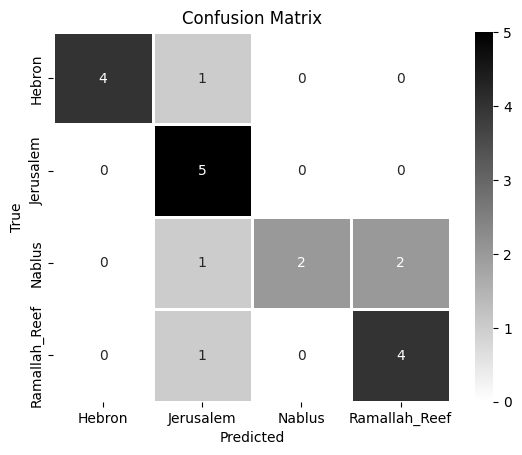

               precision    recall  f1-score   support

       Hebron       1.00      0.80      0.89         5
    Jerusalem       0.62      1.00      0.77         5
       Nablus       1.00      0.40      0.57         5
Ramallah_Reef       0.67      0.80      0.73         5

     accuracy                           0.75        20
    macro avg       0.82      0.75      0.74        20
 weighted avg       0.82      0.75      0.74        20

evaluating SVM model done.


In [122]:
print('evaluating SVM model..')
evaluate_SVM()
print('evaluating SVM model done.')